En aquesta pràctica treballareu amb un model de detecció d’objectes basat en PyTorch i la xarxa neuronal VGG16. L'objectiu es modificar el model per adaptar-lo a un problema de detecció d'objectes específic utilitzant un conjunt de dades simples.

![Exemple](08_Detecció/imgs/img.png)

Emprarem un *dataset* de detecció d'objectes que conté imatges d'estrelles. Aquest conjunt de dades és senzill i ideal per a practicar tècniques de detecció d'objectes. El podeu trobar a Kaggle al següent [enllaç](https://www.kaggle.com/datasets/kishanj/simple-object-detection). Per carregar aquest tipus de dataset haurem d'implementar una classe personalitzada que hereti de `torch.utils.data.Dataset`.

In [7]:
from torch.utils.data import Dataset
from PIL import Image
import os, torch
import xml.etree.ElementTree as ET

class EstrellesDataset(Dataset):
    def __init__(self, root_dir, transforms=None):
        super().__init__()
        self.root_dir = root_dir
        self.img_dir = os.path.join(root_dir, "images")
        self.ann_dir = os.path.join(root_dir, "annotations")
        self.transform = transforms

        self.imgs = sorted([
            f for f in os.listdir(self.img_dir)
            if f.lower().endswith(('.jpg'))
        ])

    def __len__(self):
        return len(self.imgs)


    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        img_path = os.path.join(self.img_dir, img_name)
        ann_path = os.path.join(self.ann_dir, img_name.replace(".jpg", ".xml"))

        # Llegir la imatge
        img = Image.open(img_path).convert('RGB')

        # Llegir xml
        tree = ET.parse(ann_path)
        root = tree.getroot()

        obj = root.find('object')
        bbox = obj.find('bndbox')

        xmin = int(bbox.find('xmin').text)
        xmax = int(bbox.find('xmax').text)
        ymin = int(bbox.find('ymin').text)
        ymax = int(bbox.find('ymax').text)

        bbox = torch.tensor([xmin, ymin, xmax, ymax], dtype=torch.float32) / 224
        label = torch.tensor(1, dtype=torch.int64)

        if self.transform:
            img = self.transform(img)

        return img, label, bbox

## Preparació del model

Començarem carregant el model VGG16 preentrenat i adaptant-lo per a la detecció d'objectes. Afegirem capes addicionals per predir les caixes delimitadores (bounding boxes) i les classes dels objectes.

In [8]:
from torch import nn
from torchvision import models, transforms

vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
backbone = vgg16.features

class VGG16ObjectDetector(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

        # Capes fully-connected de la VGG original
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5)
        )

        # Cap de classificació
        self.class_head = nn.Linear(4096, 1)

        # Cap de regressió de bounding box
        self.bbox_head = nn.Linear(4096, 4)

    def forward(self, x):
        x = self.backbone(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc(x)

        class_logits = self.class_head(x)
        bbox_preds = self.bbox_head(x)

        return class_logits, bbox_preds

VGG16ObjectDetector(backbone=backbone)

VGG16ObjectDetector(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, paddi

In [9]:
from torchvision import transforms
from torch.utils.data import DataLoader

# Carregam el VGG16 preentrenat
vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
backbone = vgg16.features

# Cream el nostre detector
model = VGG16ObjectDetector(backbone=backbone)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset = EstrellesDataset("archive/datasets", transforms=transform)

train_loader = DataLoader(
    dataset,
    batch_size=32,
    shuffle=True
)


In [16]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def mostra_prediccio(img, bbox_real, bbox_pred, epoch, batch_i):
    """
    Mostra una imatge amb la bbox real (verd) i predita (vermell)
    dins del bucle d'entrenament.
    """
    H, W = img.shape[1], img.shape[2]
    bbox_real = bbox_real * torch.tensor([W, H, W, H])
    bbox_pred = bbox_pred * torch.tensor([W, H, W, H])

    # Convertir a format per matplotlib
    img_np = img.permute(1, 2, 0).cpu().numpy()
    img_np = img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    img_np = img_np.clip(0, 1)

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(img_np)
    ax.set_title(f"Època {epoch+1}, Batch {batch_i}")

    # bbox real (verd)
    x1, y1, x2, y2 = bbox_real
    ax.add_patch(patches.Rectangle(
        (x1, y1), x2 - x1, y2 - y1,
        linewidth=2, edgecolor='lime', facecolor='none', label='Real'
    ))

    # bbox predita (vermell)
    x1, y1, x2, y2 = bbox_pred
    ax.add_patch(patches.Rectangle(
        (x1, y1), x2 - x1, y2 - y1,
        linewidth=2, edgecolor='red', facecolor='none', label='Predicció'
    ))

    ax.legend()
    plt.show()


Època 1/10:   0%|          | 0/4 [00:00<?, ?it/s]

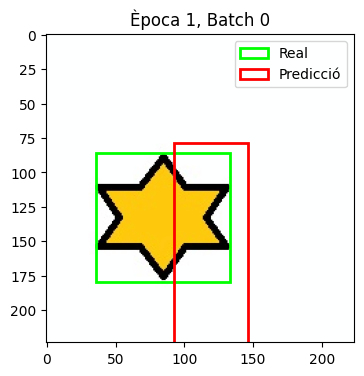

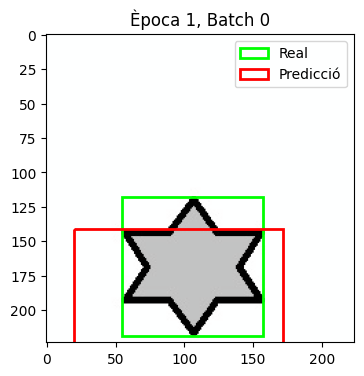

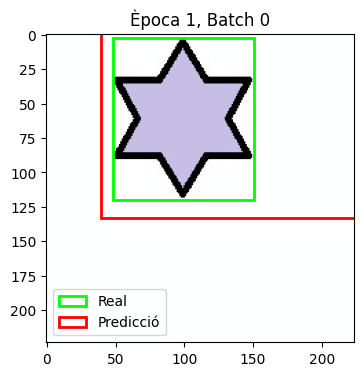

Època 1/10: 100%|██████████| 4/4 [01:10<00:00, 17.74s/it]


Època 1: pèrdua mitjana = 0.0398


Època 2/10:   0%|          | 0/4 [00:00<?, ?it/s]

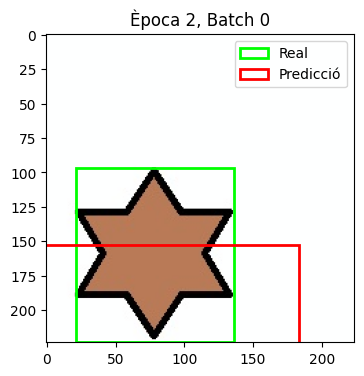

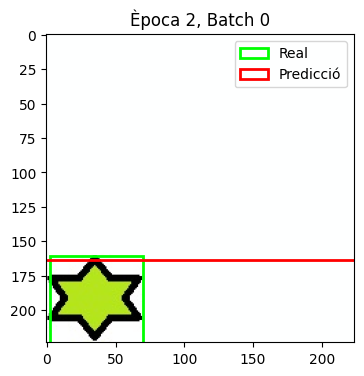

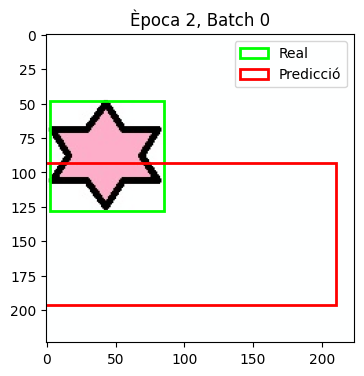

Època 2/10:  25%|██▌       | 1/4 [00:38<01:56, 39.00s/it]


KeyboardInterrupt: 

In [18]:
from torch import nn
from tqdm import tqdm

cls_loss_fn = nn.BCEWithLogitsLoss()
bbox_loss_fn = nn.SmoothL1Loss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

EPOCHS = 10

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    for imgs, labels, bboxes in tqdm(train_loader, desc=f"Època {epoch+1}/{EPOCHS}"):

        # --- Forward ---
        class_logits, bbox_preds = model(imgs)

        # --- Calcular pèrdues ---
        labels = labels.float().unsqueeze(1)  # BCE necessita float [B, 1]
        loss_cls = cls_loss_fn(class_logits, labels)
        loss_bbox = bbox_loss_fn(bbox_preds, bboxes)

        # --- Pèrdua total ---
        loss = loss_cls + loss_bbox

        # --- Backpropagation ---
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Època {epoch+1}: pèrdua mitjana = {running_loss / len(train_loader):.4f}")
